# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# **Load the CSV files & Data Cleaning**

In [2]:
customers_df = pd.read_csv('/content/Customers1.csv')
products_df = pd.read_csv('/content/Products1.csv')
transactions_df = pd.read_csv('/content/Transactions1.csv')

In [3]:
print(customers_df.head())
print(products_df.head())
print(transactions_df.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [4]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Handle Missing Values
transactions_df['TotalValue'].fillna(transactions_df['TotalValue'].mean(), inplace=True)

# Remove duplicates
customers_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
transactions_df.drop_duplicates(inplace=True)

# Check for missing values
print(customers_df.isnull().sum())
print(products_df.isnull().sum())
print(transactions_df.isnull().sum())


CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


<ipython-input-4-d6f2c66deaa2>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transactions_df['TotalValue'].fillna(transactions_df['TotalValue'].mean(), inplace=True)


In [5]:
# Define High-Value Customers (Seed Group)
top_customers = transactions_df.groupby('CustomerID')['TotalValue'].sum().nlargest(50)
high_value_customers = customers_df[customers_df['CustomerID'].isin(top_customers.index)]

print("\nHigh-Value Customers Data:")
print(high_value_customers.head())


High-Value Customers Data:
   CustomerID        CustomerName         Region SignupDate
3       C0004  Kathleen Rodriguez  South America 2022-10-09
11      C0012           Kevin May  South America 2024-08-07
12      C0013     Lauren Buchanan  South America 2024-05-19
17      C0018        Tyler Haynes  North America 2024-09-21
20      C0021    Robert Blanchard           Asia 2023-04-17


In [6]:
# Create Features for All Customers (RFM Analysis)
rfm = transactions_df.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (pd.Timestamp.now() - x.max()).days),
    Frequency=('TransactionID', 'count'),
    Monetary=('TotalValue', 'sum')
).reset_index()

# Merge Features with Customer Data
customers_with_features = pd.merge(customers_df, rfm, on='CustomerID', how='left')
customers_with_features.fillna(0, inplace=True)

print("\nCustomers with RFM Features:")
print(customers_with_features.head())

# Label High-Value Customers
customers_with_features['HighValue'] = customers_with_features['CustomerID'].isin(top_customers.index).astype(int)


Customers with RFM Features:
  CustomerID        CustomerName         Region SignupDate  Recency  \
0      C0001    Lawrence Carroll  South America 2022-07-10     84.0   
1      C0002      Elizabeth Lutz           Asia 2022-02-13     54.0   
2      C0003      Michael Rivera  South America 2024-03-07    154.0   
3      C0004  Kathleen Rodriguez  South America 2022-10-09     33.0   
4      C0005         Laura Weber           Asia 2022-08-15     83.0   

   Frequency  Monetary  
0        5.0   3354.52  
1        4.0   1862.74  
2        4.0   2725.38  
3        8.0   5354.88  
4        3.0   2034.24  


In [7]:
# Descriptive Statistics
print(customers_df.describe())
print(products_df.describe())
print(transactions_df.describe())

                SignupDate
count                  200
mean   2023-07-19 08:31:12
min    2022-01-22 00:00:00
25%    2022-09-26 12:00:00
50%    2023-08-31 12:00:00
75%    2024-04-12 12:00:00
max    2024-12-28 00:00:00
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
                     TransactionDate     Quantity   TotalValue       Price
count                           1000  1000.000000  1000.000000  1000.00000
mean   2024-06-23 15:33:02.768999936     2.537000   689.995560   272.55407
min              2023-12-30 15:29:12     1.000000    16.080000    16.08000
25%       2024-03-25 22:05:34.500000     2.000000   295.295000   147.95000
50%       2024-06-26 17:21:52.500000     3.000000   588.880000   299.93000
75%              2024-09-19 14:19:57     4.000000  1011.660000   404.40000
max              2024-12-28 11:00:00     4.000000  1991.040000   497.76000
std                   

# **Lookalike model**

In [8]:
# Feature Selection and Target Variable
features = ['Recency', 'Frequency', 'Monetary']  # Add more features if relevant
X = customers_with_features[features]
y = customers_with_features['HighValue']

# Split the Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [9]:
# Evaluate the Model
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.93      1.00      0.96        13

    accuracy                           0.98        60
   macro avg       0.96      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



In [10]:
# Predict Lookalike Customers
customers_with_features['LookalikeScore'] = model.predict_proba(X)[:, 1]

In [11]:
# Identify Top Lookalike Customers
lookalike_customers = customers_with_features[~customers_with_features['CustomerID'].isin(top_customers.index)]
lookalike_customers = lookalike_customers.sort_values('LookalikeScore', ascending=False)

print("\nTop Lookalike Customers:")
print(lookalike_customers[['CustomerID', 'LookalikeScore']].head(10))


Top Lookalike Customers:
    CustomerID  LookalikeScore
16       C0017            0.67
152      C0153            0.40
199      C0200            0.21
186      C0187            0.13
21       C0022            0.12
97       C0098            0.10
135      C0136            0.10
148      C0149            0.09
83       C0084            0.08
7        C0008            0.07


# **Customer Segmentation / Clustering**

In [12]:
# Standardize the features for clustering (RFM features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Choose the number of clusters (e.g., 4)
customers_with_features['Cluster'] = kmeans.fit_predict(X_scaled)

# Display the clusters
print("\nCustomer Segmentation (Clustering):")
print(customers_with_features[['CustomerID', 'Cluster']].head())



Customer Segmentation (Clustering):
  CustomerID  Cluster
0      C0001        3
1      C0002        1
2      C0003        1
3      C0004        0
4      C0005        1


In [13]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for PCA components
pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customers_with_features['Cluster']

# **Visualizations**

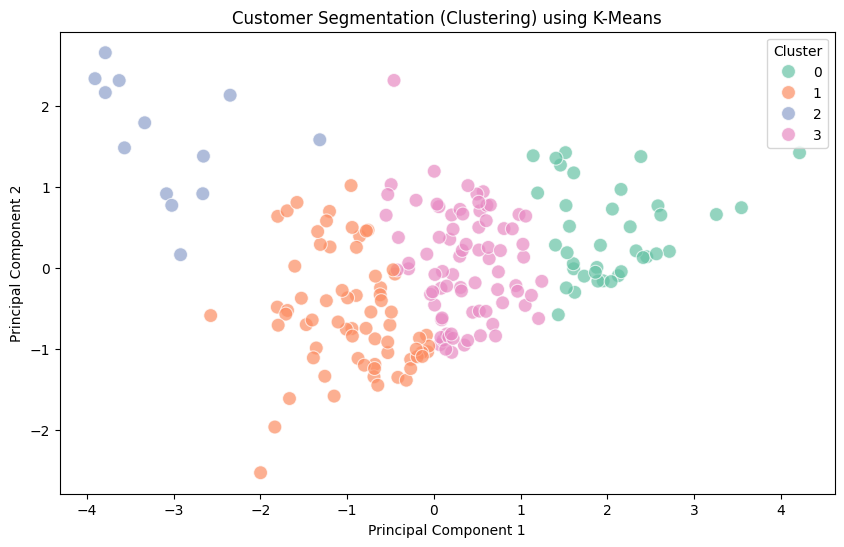

In [14]:
# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=pca_df, s=100, alpha=0.7)
plt.title('Customer Segmentation (Clustering) using K-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

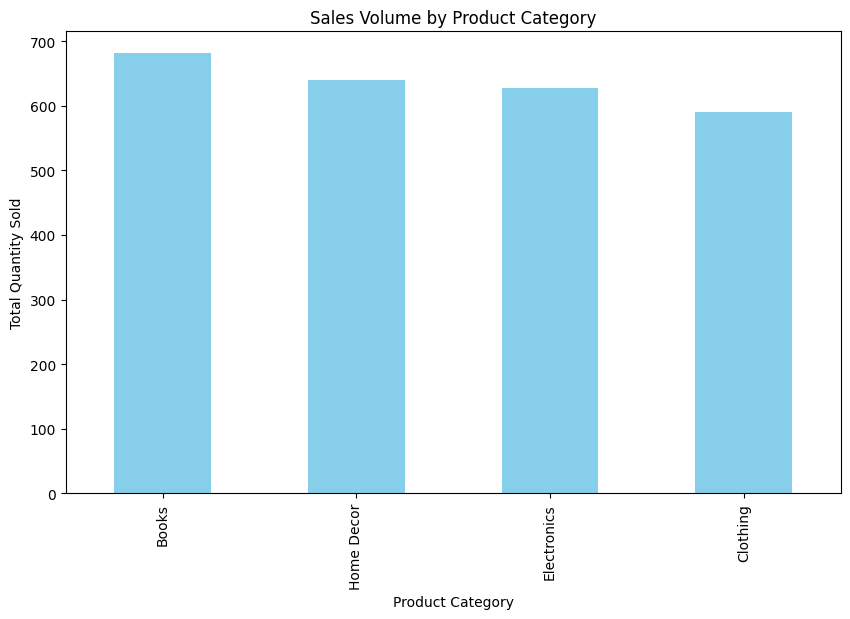

In [15]:
# 1. Sales Volume by Category
merged_df = pd.merge(transactions_df, products_df, on='ProductID', how='inner')
category_sales = merged_df.groupby('Category')['Quantity'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar', color='skyblue')
plt.title('Sales Volume by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Quantity Sold')
plt.show()


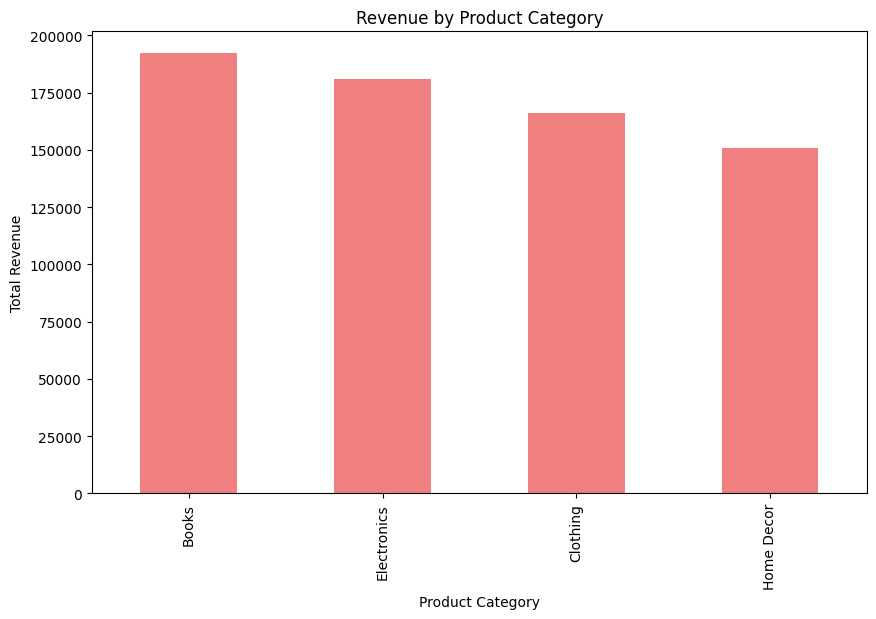

In [16]:
# 2. Revenue by Product Category
category_revenue = merged_df.groupby('Category')['TotalValue'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
category_revenue.plot(kind='bar', color='lightcoral')
plt.title('Revenue by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.show()

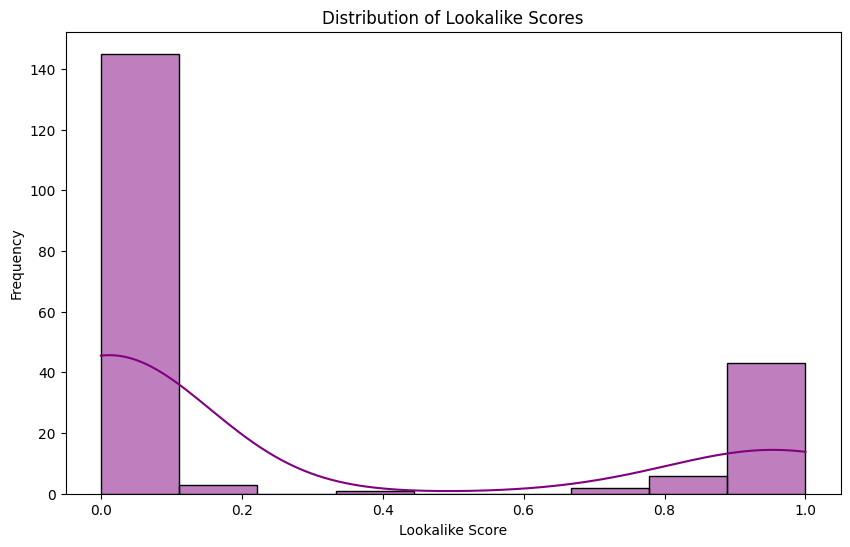

In [17]:
# 3. Lookalike Scores Distribution
plt.figure(figsize=(10, 6))
sns.histplot(customers_with_features['LookalikeScore'], kde=True, color='purple')
plt.title('Distribution of Lookalike Scores')
plt.xlabel('Lookalike Score')
plt.ylabel('Frequency')
plt.show()


<ipython-input-18-5c26025f1144>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Region', data=customers_df, palette='viridis')


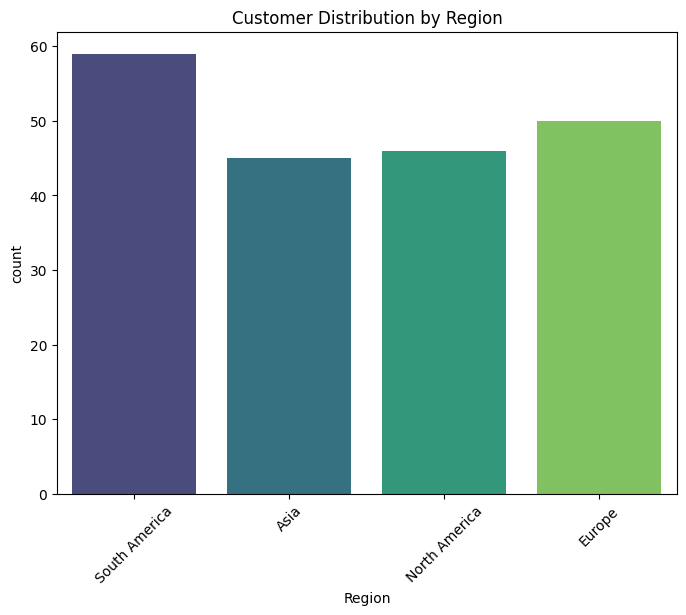

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(x='Region', data=customers_df, palette='viridis')
plt.title('Customer Distribution by Region')
plt.xticks(rotation=45)
plt.show()


<ipython-input-19-f2662b2993f5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Category', data=products_df, palette='coolwarm')


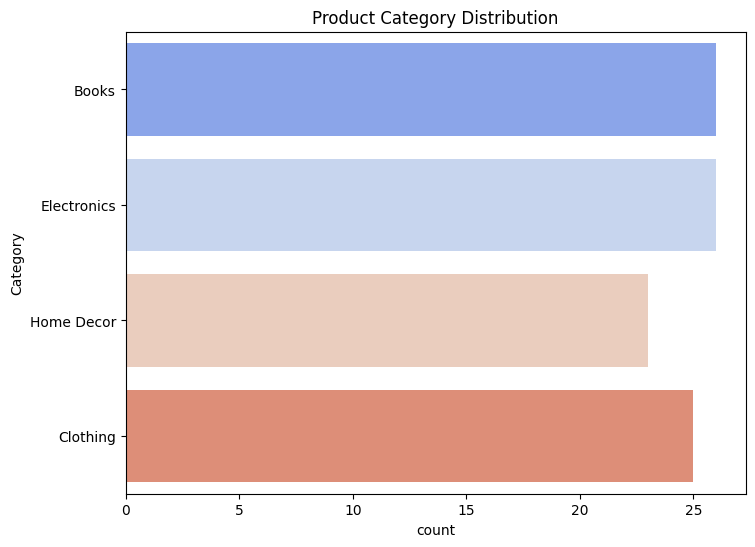

In [19]:
plt.figure(figsize=(8,6))
sns.countplot(y='Category', data=products_df, palette='coolwarm')
plt.title('Product Category Distribution')
plt.show()

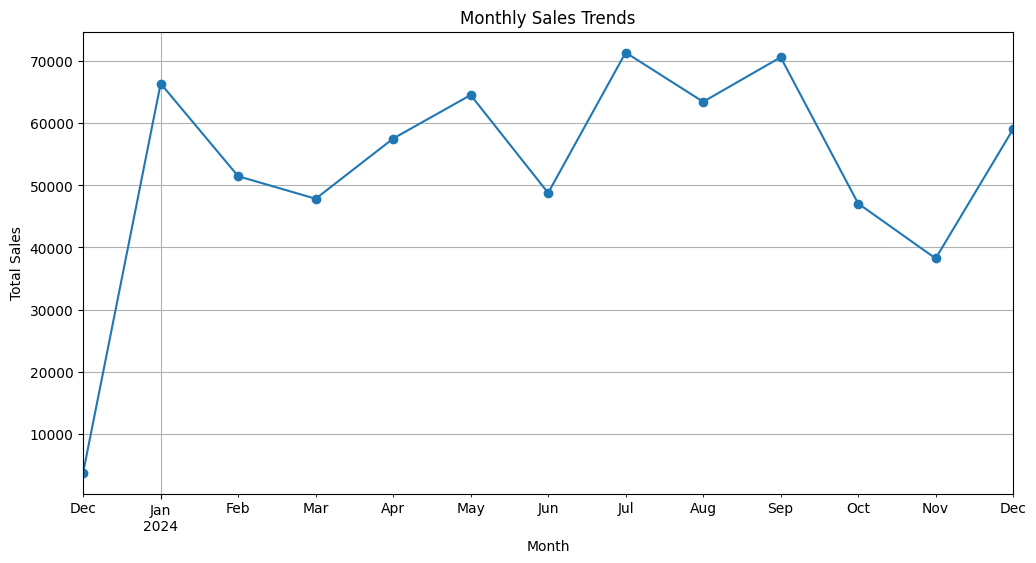

In [20]:
transactions_df['TransactionMonth'] = transactions_df['TransactionDate'].dt.to_period('M')
monthly_sales = transactions_df.groupby('TransactionMonth')['TotalValue'].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid()
plt.show()


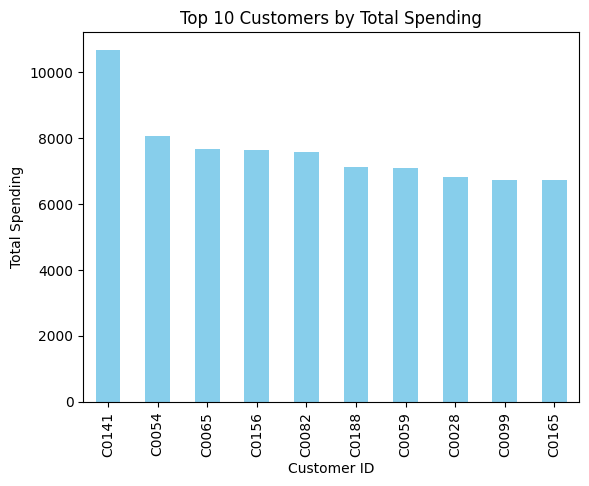

In [21]:
top_customers = transactions_df.groupby('CustomerID')['TotalValue'].sum().nlargest(10)
top_customers.plot(kind='bar', color='skyblue')
plt.title('Top 10 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Spending')
plt.show()


# **Save insights to report**

In [22]:

# Step 1: Extract insights dynamically from data
highest_region = customers_df['Region'].mode()[0]  # Most frequent region
top_product_category = products_df['Category'].mode()[0]  # Most frequent product category
seasonal_peak_month = transactions_df['TransactionDate'].dt.month.value_counts().idxmax()  # Peak sales month
top_revenue_customers = transactions_df.groupby('CustomerID')['TotalValue'].sum().nlargest(1).index[0]  # Top spender
total_revenue_customers = transactions_df.groupby('CustomerID')['TotalValue'].sum()
percent_top_customers = (total_revenue_customers.nlargest(10).sum() / total_revenue_customers.sum()) * 100

# Step 2: Write insights to the report file
report_content = f"""
Exploratory Data Analysis (EDA) Report
-----------------------------------------------------
Key Insights:
1. Customer distribution is highest in {highest_region} region.
2. The most popular product category is {top_product_category}.
3. Sales show seasonal trends peaking in month {seasonal_peak_month}.
4. A small percentage of customers contribute to {percent_top_customers:.2f}% of the total revenue.
5. Frequent customers could be targeted for loyalty programs, with Customer ID {top_revenue_customers} being the top spender.
"""

# Save the report to a text file
with open("EDA_Report.txt", "w") as report:
    report.write(report_content)

print("EDA Report successfully saved as 'EDA_Report.txt'")


EDA Report successfully saved as 'EDA_Report.txt'
